In [1]:
!git clone --single-branch --branch 'simplified-version' 'https://github.com/LuchnikovI/Dynamic-mode-decomposition-for-open-quantum-systems-identification'
%cd 'Dynamic-mode-decomposition-for-open-quantum-systems-identification'
import math
import tensorflow as tf
import matplotlib.pyplot as plt

from nmd_finite_env import FiniteEnv
from embedding import Embedding

Cloning into 'Dynamic-mode-decomposition-for-open-quantum-systems-identification'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 152 (delta 86), reused 90 (delta 37), pack-reused 0
Receiving objects: 100% (152/152), 468.36 KiB | 16.73 MiB/s, done.
Resolving deltas: 100% (86/86), done.
/content/Dynamic-mode-decomposition-for-open-quantum-systems-identification


First, we simulate non-markovian dynamics with a finite-size reservoir. Dynamics is driven by a Lindblad equation with a randomly generated generator $$\frac{d\rho}{d t} = -ia_h[H, \rho] + a_d\sum_{ij}^{N^2-1}\gamma_{ij}\left(F_i \rho F^\dagger_j - \frac{1}{2}\{F^\dagger_j F_i, \rho\}\right),$$ where $N$ is the dimension of the (system + memory) Hilbert space, $H$ is a hermitian matrix that is generated in the following way:
$$H = \frac{1}{2}\left(A + A^\dagger\right), \ {\rm Re}(A), \ {\rm Im}(A)\sim N(0, I),$$
$\gamma$ is psd matrix that is gegerated as follows:
$$\gamma = AA^\dagger, \ {\rm Re}(A), \ {\rm Im}(A)\sim N(0, I),$$
$a_h$ and $a_d$ are amplitudes (positive scalars) of hermitian and dissipative parts respectively.
We collect a set of trajectories in discrete time $\{\rho_j(k\tau)\}_{j,k=1}^{j=M, k=T}$, where $k$ is disrete time, $\tau$ is a time step, $j$ is a number of trajectories, $T$ is a total number of discrete time steps, $M$ is a total number of trajectories.

Then we use set $\{\rho_j(k\tau)\}_{j,k=1}^{j=M, k=T}$ to build data driven model of the dynamics. We use dmd approach to find solution of the following optimization problem $$\|TX - Y\|_F\rightarrow \min_T$$ in low rank format $T = C^{-1} \Lambda C$, where $X$ and $Y$ are Hankel matrices built from trajectories. Then we use a learned $T$ to reconstruct a number of properties of a system.

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


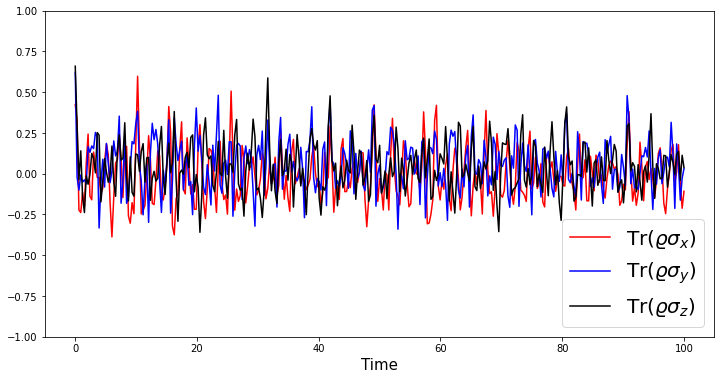

In [62]:
#------------------------Parameters------------------------#
dissipation_ampl = 0.001 # amplitude of dissipation
hamiltonian_ampl = 1 # amplitude of the hamiltonian part
time_step = 0.3  # time step size
total_time = 100  # total simulation time
number_of_lines = 2  # number of parallel experiments
size_of_mem = 3  # memory size
#----------------------------------------------------------#

# pauli matrices
sigma_x = tf.constant([[0, 1], [1, 0]], dtype=tf.complex128)
sigma_y = 1j * tf.constant([[0, -1], [1, 0]], dtype=tf.complex128)
sigma_z = tf.constant([[1, 0], [0, -1]], dtype=tf.complex128)

# all pauli matrices in one tensor
pauli = tf.concat([sigma_x[tf.newaxis],
                   sigma_y[tf.newaxis],
                   sigma_z[tf.newaxis]], axis=0)

# model initializing
model = FiniteEnv(2, size_of_mem)
model.set_rand_gen(dissipation_ampl, hamiltonian_ampl)

# random pure initial states
psi_re = tf.random.normal((number_of_lines, 2), dtype=tf.float64)
psi_im = tf.random.normal((number_of_lines, 2), dtype=tf.float64)
psi = tf.complex(psi_re, psi_im)
psi = psi / tf.linalg.norm(psi, axis=1, keepdims=True)
rho = psi[:, tf.newaxis] * tf.math.conj(psi)[..., tf.newaxis]

# dynamics simulation
train_set = model.dynamics(total_time, time_step, rho)
X_train = tf.tensordot(train_set, pauli, [[2, 3], [2, 1]])

# plotting some dynamics
time = tf.linspace(0, total_time, X_train.shape[1])
plt.figure(figsize=(12, 6))
plt.plot(time, X_train[0, :, 0], 'r')
plt.plot(time, X_train[0, :, 1], 'b')
plt.plot(time, X_train[0, :, 2], 'k')
plt.ylim(top=1, bottom=-1)
plt.xlabel('Time', fontsize=15)
plt.legend([r'${\rm Tr}(\varrho \sigma_x)$',
            r'${\rm Tr}(\varrho \sigma_y)$',
            r'${\rm Tr}(\varrho \sigma_z)$'], fontsize=20)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/

Minimal rank = 34
True rank = 36


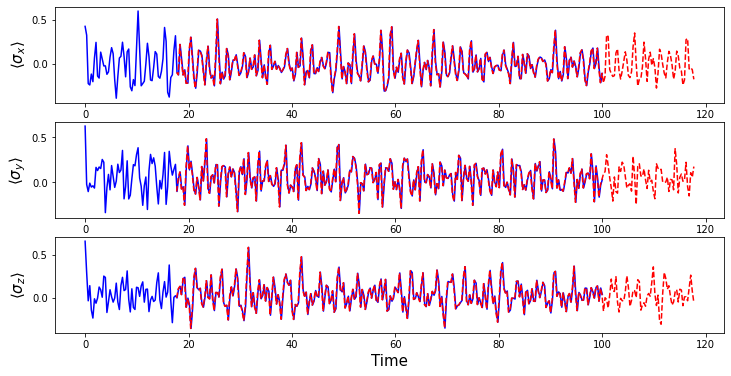

In [64]:
#------------------------Parameters--------------------------#
K = 60  # memory depth
eps = 1e-6  # tolerance
#------------------------------------------------------------#

# embedding
emb = Embedding()
# learn embedding
emb.learn(train_set, K, eps)
# min rank
rank = emb.rank
# prediction
test_set = model.dynamics(total_time, time_step, rho)
prediction = emb.predict(test_set[0, :K],
                         test_set.shape[1])
# corresponding bloch vectors
X_predicted = tf.tensordot(prediction, pauli, [[1, 2], [2, 1]])
# test bloch vectors
X_test = tf.tensordot(test_set, pauli, [[2, 3], [2, 1]])


# plotting
time = tf.linspace(0, total_time, X_test.shape[1])
plt.figure(figsize=(12, 6))
plt.subplot(311)
plt.plot(time, X_test[0, :, 0], 'b')
plt.plot(time + (K - 1) * time_step, X_predicted[:, 0], 'r--')
plt.ylabel(r'$\langle\sigma_x\rangle$', fontsize=15)
plt.subplot(312)
plt.plot(time, X_test[0, :, 1], 'b')
plt.plot(time + (K - 1) * time_step, X_predicted[:, 1], 'r--')
plt.ylabel(r'$\langle\sigma_y\rangle$', fontsize=15)
plt.subplot(313)
plt.plot(time, X_test[0, :, 2], 'b')
plt.plot(time + (K - 1) * time_step, X_predicted[:, 2], 'r--')
plt.xlabel('Time', fontsize=15)
plt.ylabel(r'$\langle\sigma_z\rangle$', fontsize=15)
print('Minimal rank = {}'.format(rank))
print('True rank = {}'.format(4 * size_of_mem ** 2))

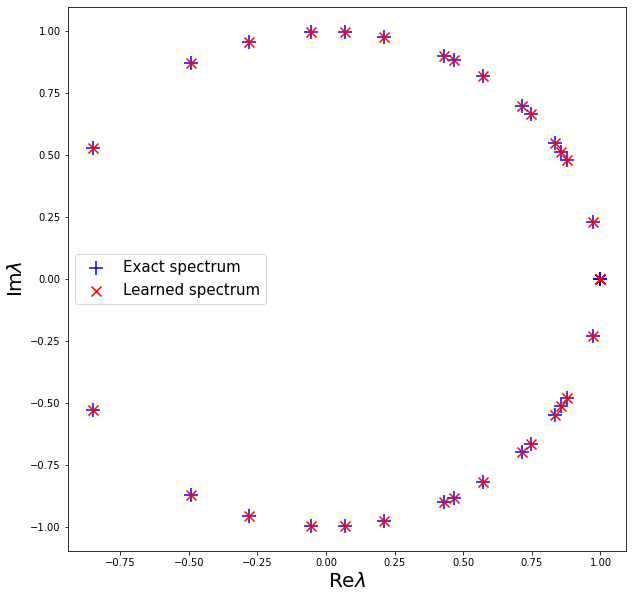

In [65]:
# exact eigenvalues
true_gen_lmbd, _ = tf.linalg.eig(model.gen)
true_phi_lmbd = tf.math.exp(time_step * true_gen_lmbd)

# learned eigenvalues
learned_phi_lmbd = emb.channel

# plotting of the spectrum
plt.figure(figsize=(10, 10))
plt.scatter(tf.math.real(true_phi_lmbd),
            tf.math.imag(true_phi_lmbd), color='b', marker='+', s=200)
plt.scatter(tf.math.real(learned_phi_lmbd),
            tf.math.imag(learned_phi_lmbd), marker='x', color='red', s=100)
plt.xlabel(r'${\rm Re}\lambda$', fontsize=20)
plt.ylabel(r'${\rm Im}\lambda$', fontsize=20)
plt.legend(['Exact spectrum', 'Learned spectrum'], fontsize=15)